<a href="https://colab.research.google.com/github/yeipi-mora/personal-projects/blob/main/sandpiles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# powerlaw instalation
!pip install powerlaw
!pip install networkx

In [ ]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt
import powerlaw
import random
import time
import networkx as nx

In [ ]:
'''
  Several functions to deal with topplings and stabilization of
  grid graphs.
'''

def topple_grid(S: np.array, T: np.array, x: int, y: int):
    '''
     Fire a single site in S once
     i.e. increment odometer
     remove chips from S[x, y]
     and give chips to neighbors
     (x+1, y), (x-1, y), (x, y+1), (x, y-1)

     Returns True if we have toppled and False other case
    '''
    # Number of times fire site (x, y)
    # We take max in case there is a hole at (x, y)
    z = max(np.floor(S[x, y] / 4), 0)

    # Increment the odometer
    T[x, y] += z
    S[x, y] -= 4 * z

    # Give sand to each neighbor
    if x > 0:
      S[x - 1, y] += z
    if x < S.shape[0] - 1:
      S[x + 1, y] += z
    if y > 0:
      S[x, y - 1] += z
    if y < S.shape[1] - 1:
      S[x, y + 1] += z

    return z > 0

def stabilize_grid(S: np.array):
    # Initialize the all 0 odometer
    T = np.zeros_like(S)
    # Iterate over all sites and try to topple
    # until it is not possible anymore

    # Counter of avalanches.
    c = -1
    is_topple = True
    while is_topple:
      c  += 1
      is_topple = False
      for y in range(S.shape[1]):
        for x in range(S.shape[0]):
          is_topple = is_topple or topple_grid(S, T, x, y)
    return S, c

def random_config_grid(N: int):

  # Create a random configuration S of size N x N
  S = np.random.randint(low=0, high=4, size=(N, N))
  #print(S)
  # List to store the size of the avalanche.
  L = list()
  for _ in range(1000):
      # Pick a random vertex and add one grain
      random_vertex = (np.random.randint(0, N), np.random.randint(0, N))
      S[random_vertex] += 1
      #print(random_vertex)
      #print(S)
      S, c = stabilize_grid(S)
      #print(S)
      L.append(c)
  return L

In [ ]:
'''
  Several functions to deal with topplings and stabilization of
  general graphs.
'''

def topple(G: dict, c: list, v: int):

  '''
    We will topple a graph G represented by a dictionary
    Inputs:
      - G: representation of G as a dictionary: G[v] is a list of vertices adjacent to v
      - c: configuration of grains
      - v: vertex that we will topple

      Return:
        - We return a True statement if we topple v. False in other case.
  '''

  # Number of neighbors of v.
  n = len(G[v])
  grains = c[v]
  if c[v] >= n:
    for w in G[v]:
      c[w] += 1
      c[v] -= 1
  return grains >= n

def stabilize(G: dict, c: list):
  '''
    We stabilize a graph G represented by its dictionary.

    Inputs:
      - G: Graph represented by a dictionary
      - c: configuration of sand
    Output:
      - We return the stable configuration
  '''
  # Iterate over all sites and try to topple
  # until it is not possible anymore
  # Counter
  k = 0
  for v in range(1,len(G.keys())):
      is_topple = topple(G,c,v)
      if is_topple: k += 1
  return c, k

def evolutive(G: dict, c: list):
  '''
    We stabilize over a discrete evolution of graphs
    Inputs:
      - G: a dictionary to stores each graph G_{t} (represented by a dictionary).
            A key of G corresponds to the discrete time t.
      - c: an initial (random) configuration.
    Output:
      - L: a list representing the size of 1000 avalanches.
  '''
  L = list()
  t = 0
  for i in range(10000):
    m = 0
    random_vertex = np.random.randint(1, len(G[t].keys()))
    c[random_vertex] += 1
    while True:
      c, k = stabilize(G[t],c)
      m += k
      t += 1
      t %= len(G.keys())
      if k == 0: break
    L.append(m)
  return L

In [ ]:
def evolutive_hor_ver(n, m, horizontal=True):
  """Creates a grid with just horizontal lines or just vertical lines"""
  G = nx.grid_2d_graph(n, m)

  if horizontal:
    # Delete horizontal edges
    for i in range(n):
      for j in range(m-1):
        G.remove_edge((i,j),(i,j+1))
  else:
    # Delete vertical edges
    for j in range(m):
        for i in range(n-1):
            G.remove_edge((i,j),(i+1,j))

  # Connect vertex 0 with the boundary of G
  G.add_node(0)
  for i in range(n):
      G.add_edge(0, (i,0))
      G.add_edge(0, (i,m-1))
  for i in range(m):
      G.add_edge(0, (0,i))
      G.add_edge(0, (n-1,i))

  # Relabel vertices
  mapping = {(i,j): m*i+j+1 for i in range(n) for j in range(m)}
  mapping[0] = 0
  G = nx.relabel_nodes(G, mapping)

  # Convert to dictionary representation
  return nx.to_dict_of_lists(G)

def evolutive_diamond(n, m, diamond=True):
  if diamond:
    G = nx.Graph()
    for i in range(n):
        for j in range(m):
            G.add_node((i, j))
            if i < n - 1 and j < m - 1:
              G.add_edge((i, j), (i + 1, j + 1))
            if j > 0 and i < n - 1:
              G.add_edge((i, j), (i + 1, j - 1))
  else:
    G = nx.grid_2d_graph(n, m)

  # Connect vertex 0 with the boundary of G
  G.add_node(0)
  for i in range(n):
      G.add_edge(0, (i,0))
      G.add_edge(0, (i,m-1))
  for i in range(m):
      G.add_edge(0, (0,i))
      G.add_edge(0, (n-1,i))

  # Relabel vertices
  mapping = {(i,j): m*i+j+1 for i in range(n) for j in range(m)}
  mapping[0] = 0

  G = nx.relabel_nodes(G, mapping)

  return nx.to_dict_of_lists(G)

def evolutive_double(n, m, horizontal):
  """Creates a grid with two horizontal lines"""
  G = nx.grid_2d_graph(n, m)
  D = nx.to_dict_of_lists(G)
  if horizontal:
    for i in range(n):
      for j in range(m):
        if j < m-1:
          D[(i,j)].append((i,j+1))
        if j > 0:
          D[(i,j)].append((i,j-1))
  else:
    for i in range(n):
      for j in range(m):
        if i < n-1:
          D[(i,j)].append((i+1,j))
        if i > 0:
          D[(i,j)].append((i-1,j))

  H  = {}
  # Relabel vertices
  for (i, j), N in D.items():
    H[m*i+j+1] = [m*p+q+1 for (p, q) in N]
    H[m*i+j+1].append(0)
  # Connect vertex 0 with the boundary of G
  H[0] = [v for v in H.keys()]
  return H

In [ ]:
n, m = 10, 10
G0 = evolutive_hor_ver(n, m)
G1 = evolutive_hor_ver(n, m, False)
G = {0: G0, 1: G1}
conf = [np.random.randint(0,2) for _ in range(len(G0.keys()))]
l10 = evolutive(G,conf)
l10.sort(reverse=True)

In [ ]:
n, m = 50, 50
G0 = evolutive_hor_ver(n, m)
G1 = evolutive_hor_ver(n, m, False)
G = {0: G0, 1: G1}
conf = [np.random.randint(0,2) for _ in range(len(G0.keys()))]
l50 = evolutive(G,conf)
l50.sort(reverse=True)

In [ ]:
n, m = 100, 100
G0 = evolutive_hor_ver(n, m)
G1 = evolutive_hor_ver(n, m, False)
G = {0: G0, 1: G1}
conf = [np.random.randint(0,2) for _ in range(len(G0.keys()))]
l100 = evolutive(G,conf)
l100.sort(reverse=True)

Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


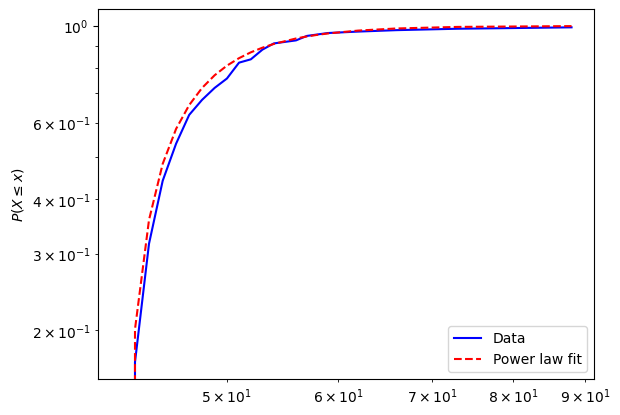

In [ ]:
#plt.plot(l10)
#plt.ylabel('Number of topplings')
#plt.show()
fit = powerlaw.Fit(l10)
fig = fit.plot_cdf(color='b', label='Data')
fit.power_law.plot_cdf(color='r', linestyle='--', ax=fig, label='Power law fit')
fig.set_ylabel('$P(X\leq x)$')
plt.legend()
plt.show()

Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


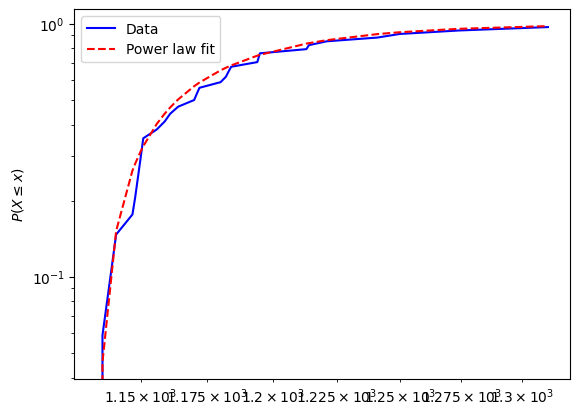

In [ ]:
#plt.plot(l50)
#plt.ylabel('Number of topplings')
#plt.show()
fit = powerlaw.Fit(l50)
fig = fit.plot_cdf(color='b', label='Data')
fit.power_law.plot_cdf(color='r', linestyle='--', ax=fig, label='Power law fit')
fig.set_ylabel('$P(X\leq x)$')
plt.legend()
plt.show()

Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


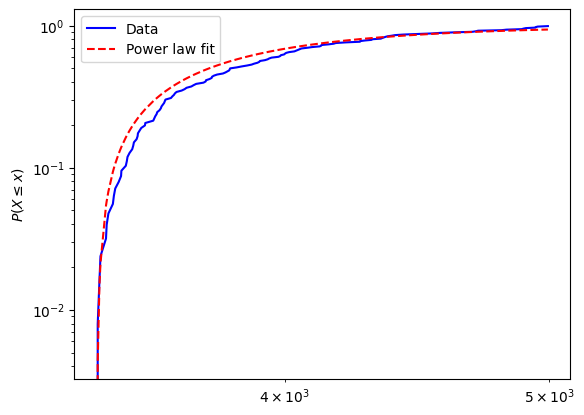

In [ ]:
#plt.plot(l100)
#plt.ylabel('Number of topplings')
#plt.show()
fit = powerlaw.Fit(l100)
fig = fit.plot_cdf(color='b', label='Data')
fit.power_law.plot_cdf(color='r', linestyle='--', ax=fig, label='Power law fit')
fig.set_ylabel('$P(X\leq x)$')
plt.legend()
plt.show()

In [ ]:
n, m = 10, 10
G0 = evolutive_diamond(n, m)
G1 = evolutive_diamond(n, m, False)
G = {0: G0, 1: G1}
conf = [np.random.randint(0,2) for _ in range(len(G0.keys()))]
d10 = evolutive(G,conf)
d10.sort(reverse=True)

In [ ]:
n, m = 50, 50
G0 = evolutive_diamond(n, m)
G1 = evolutive_diamond(n, m, False)
G = {0: G0, 1: G1}
conf = [np.random.randint(0,2) for _ in range(len(G0.keys()))]
d50 = evolutive(G,conf)
d50.sort(reverse=True)

In [ ]:
n, m = 100, 100
G0 = evolutive_diamond(n, m)
G1 = evolutive_diamond(n, m, False)
G = {0: G0, 1: G1}
conf = [np.random.randint(0,2) for _ in range(len(G0.keys()))]
d100 = evolutive(G,conf)
d100.sort(reverse=True)

In [ ]:
n, m = 200, 200
G0 = evolutive_diamond(n, m)
G1 = evolutive_diamond(n, m, False)
G = {0: G0, 1: G1}
conf = [np.random.randint(0,2) for _ in range(len(G0.keys()))]
d200 = evolutive(G,conf)
d200.sort(reverse=True)

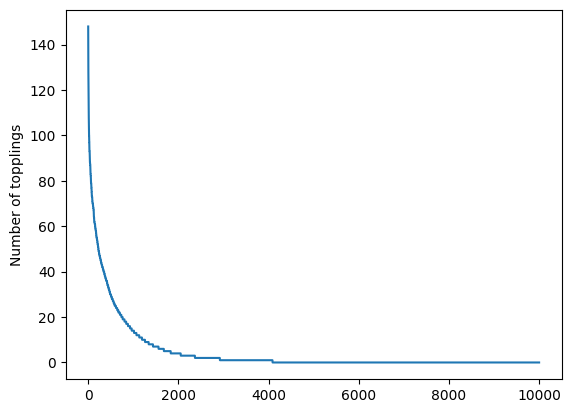

Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


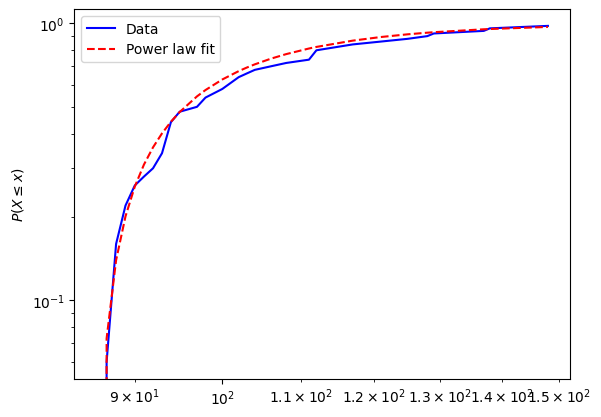

In [ ]:
plt.plot(d10)
plt.ylabel('Number of topplings')
plt.show()
fit = powerlaw.Fit(d10)
fig = fit.plot_cdf(color='b', label='Data')
fit.power_law.plot_cdf(color='r', linestyle='--', ax=fig, label='Power law fit')
fig.set_ylabel('$P(X\leq x)$')
plt.legend()
plt.show()

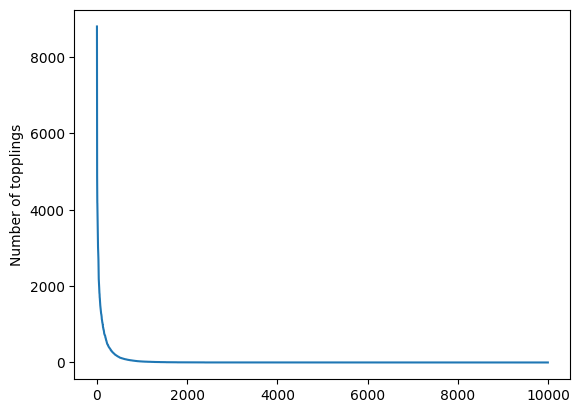

Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


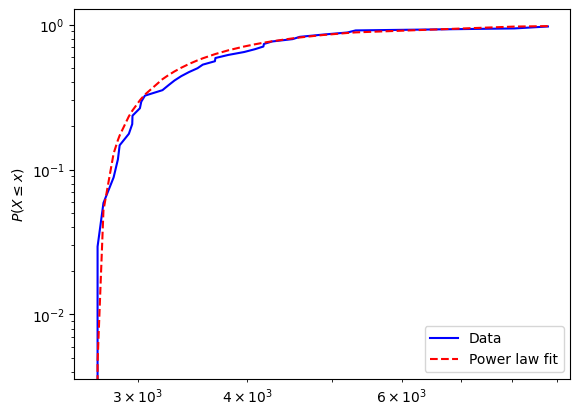

In [ ]:
plt.plot(d50)
plt.ylabel('Number of topplings')
plt.show()
fit = powerlaw.Fit(d50)
fig = fit.plot_cdf(color='b', label='Data')
fit.power_law.plot_cdf(color='r', linestyle='--', ax=fig, label='Power law fit')
fig.set_ylabel('$P(X\leq x)$')
plt.legend()
plt.show()

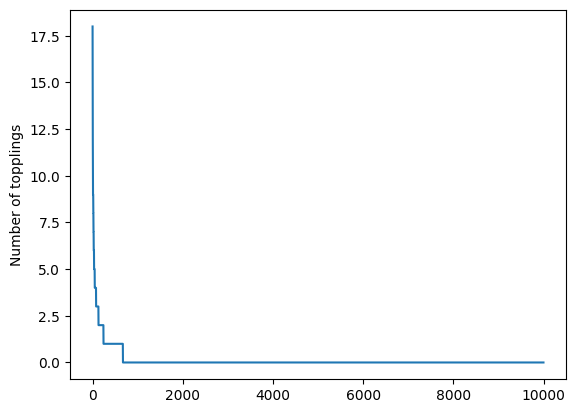

Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


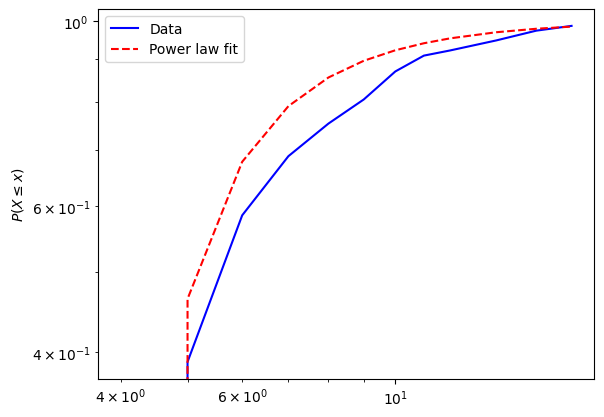

In [ ]:
plt.plot(d100)
plt.ylabel('Number of topplings')
plt.show()
fit = powerlaw.Fit(d100)
fig = fit.plot_cdf(color='b', label='Data')
fit.power_law.plot_cdf(color='r', linestyle='--', ax=fig, label='Power law fit')
fig.set_ylabel('$P(X\leq x)$')
plt.legend()
plt.show()

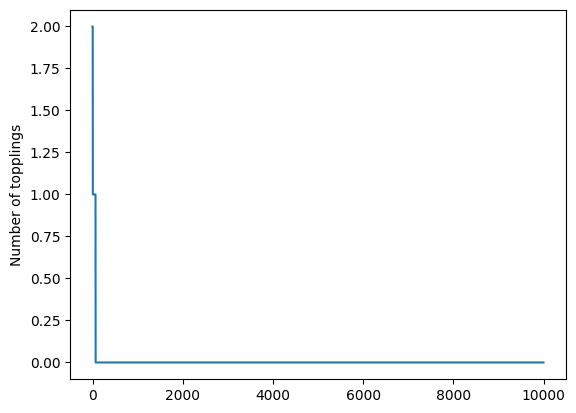

Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


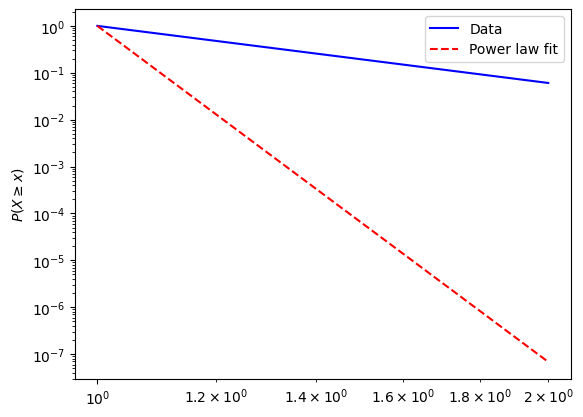

In [ ]:
plt.plot(d200)
plt.ylabel('Number of topplings')
plt.show()
fit = powerlaw.Fit(d200)
fig = fit.plot_ccdf(color='b', label='Data')
fit.power_law.plot_ccdf(color='r', linestyle='--', ax=fig, label='Power law fit')
fig.set_ylabel('$P(X\geq x)$')
plt.legend()
plt.show()

In [ ]:
n, m = 10, 10
G0 = evolutive_double(n, m, False)
G1 = evolutive_double(n, m, True)
G = {0: G0, 1: G1}
conf = [np.random.randint(0,5) for _ in range(len(G0.keys()))]
e10 = evolutive(G,conf)
e10.sort(reverse=True)

In [ ]:
n, m = 50, 50
G0 = evolutive_double(n, m, False)
G1 = evolutive_double(n, m, True)
G = {0: G0, 1: G1}
conf = [np.random.randint(0,5) for _ in range(len(G0.keys()))]
e50 = evolutive(G,conf)
e50.sort(reverse=True)

In [ ]:
n, m = 100, 100
G0 = evolutive_double(n, m, False)
G1 = evolutive_double(n, m, True)
G = {0: G0, 1: G1}
conf = [np.random.randint(0,5) for _ in range(len(G0.keys()))]
e500 = evolutive(G,conf)
e500.sort(reverse=True)

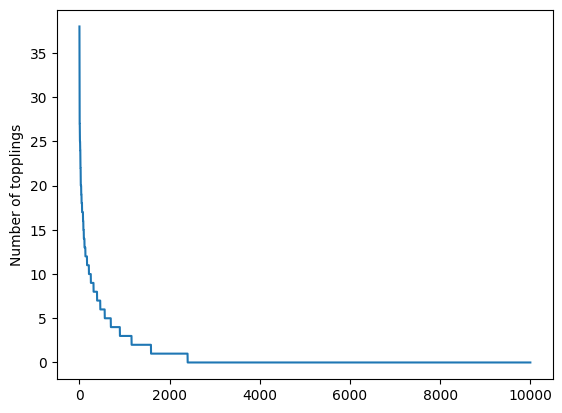

Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


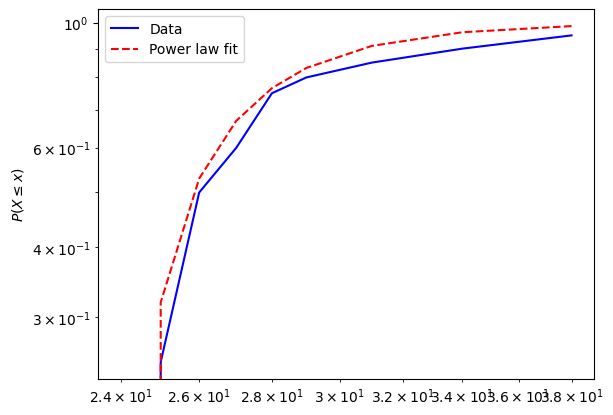

In [ ]:
plt.plot(e10)
plt.ylabel('Number of topplings')
plt.show()
fit = powerlaw.Fit(e10)
fig = fit.plot_ccdf(color='b', label='Data')
fit.power_law.plot_ccdf(color='r', linestyle='--', ax=fig, label='Power law fit')
fig.set_ylabel('$P(X\leq x)$')
plt.legend()
plt.show()

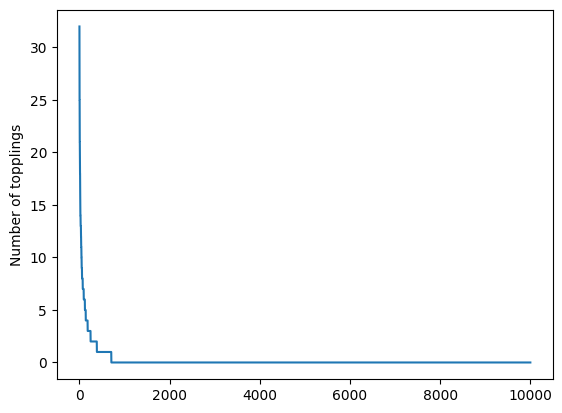

Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


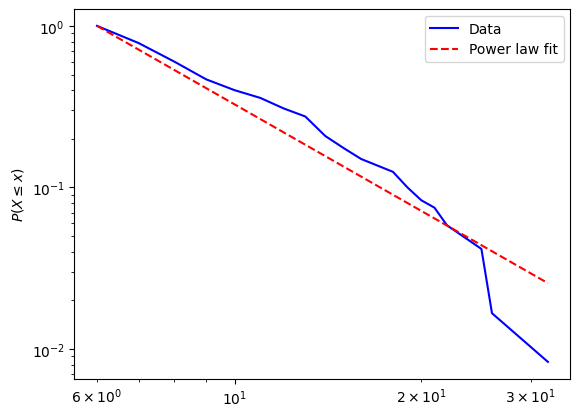

In [ ]:
plt.plot(e50)
plt.ylabel('Number of topplings')
plt.show()
fit = powerlaw.Fit(e50)
fig = fit.plot_cdf(color='b', label='Data')
fit.power_law.plot_cdf(color='r', linestyle='--', ax=fig, label='Power law fit')
fig.set_ylabel('$P(X\leq x)$')
plt.legend()
plt.show()

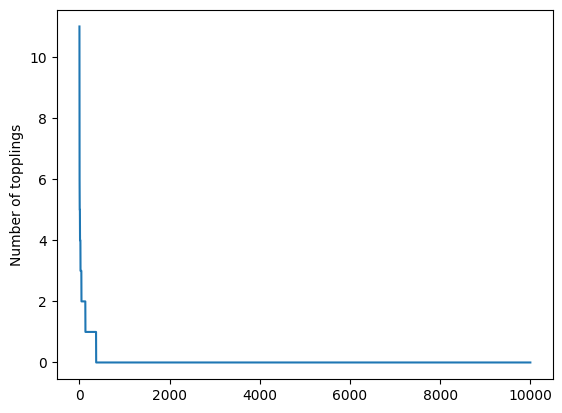

Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


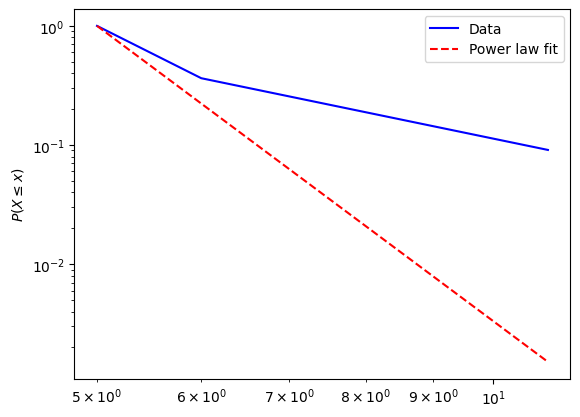

In [ ]:
plt.plot(e500)
plt.ylabel('Number of topplings')
plt.show()
fit = powerlaw.Fit(e500)
fig = fit.plot_ccdf(color='b', label='Data')
fit.power_law.plot_ccdf(color='r', linestyle='--', ax=fig, label='Power law fit')
fig.set_ylabel('$P(X\leq x)$')
plt.legend()
plt.show()

In [ ]:
e50[0]

32